In [1]:
import cv2
import numpy as np
import torch
import HOPLS
from torchvision.models import resnet18, ResNet50_Weights
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pickle
import pandas as pd
%matplotlib inline

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Обработаем видео и представим в формате np.array

In [2]:
def video_to_numpy(video):
    images = []
    cap = cv2.VideoCapture(video)
    while not cap.isOpened():
        cap = cv2.VideoCapture(video)
        cv2.waitKey(1000)
        print("Wait for the header")
    pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    while True:
        flag, frame = cap.read()
        if flag:
            # The frame is ready and already captured
            frame = frame.transpose(2, 0, 1)
            images.append(frame)
            pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            print (str(pos_frame)+" frames")
        else:
            # The next frame is not ready, so we try to read it again
            cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, pos_frame-1)
            print("frame is not ready")
            # It is better to wait for a while for the next frame to be ready
            cv2.waitKey(1000)
        if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            # If the number of captured frames is equal to the total number of frames,
            # we stop
            break
    all_frames = np.array(images)
    return all_frames

Возьмем одно из видео движения глаз из датасета

In [3]:
video = video_to_numpy('./LPW/LPW/1/1.avi')

1.0 frames
2.0 frames
3.0 frames
4.0 frames
5.0 frames
6.0 frames
7.0 frames
8.0 frames
9.0 frames
10.0 frames
11.0 frames
12.0 frames
13.0 frames
14.0 frames
15.0 frames
16.0 frames
17.0 frames
18.0 frames
19.0 frames
20.0 frames
21.0 frames
22.0 frames
23.0 frames
24.0 frames
25.0 frames
26.0 frames
27.0 frames
28.0 frames
29.0 frames
30.0 frames
31.0 frames
32.0 frames
33.0 frames
34.0 frames
35.0 frames
36.0 frames
37.0 frames
38.0 frames
39.0 frames
40.0 frames
41.0 frames
42.0 frames
43.0 frames
44.0 frames
45.0 frames
46.0 frames
47.0 frames
48.0 frames
49.0 frames
50.0 frames
51.0 frames
52.0 frames
53.0 frames
54.0 frames
55.0 frames
56.0 frames
57.0 frames
58.0 frames
59.0 frames
60.0 frames
61.0 frames
62.0 frames
63.0 frames
64.0 frames
65.0 frames
66.0 frames
67.0 frames
68.0 frames
69.0 frames
70.0 frames
71.0 frames
72.0 frames
73.0 frames
74.0 frames
75.0 frames
76.0 frames
77.0 frames
78.0 frames
79.0 frames
80.0 frames
81.0 frames
82.0 frames
83.0 frames
84.0 frames
8

Пресказывать изображения по последовательности изображний с помошью HOPLSна практике невозможно, т.к. при подсчете с помощью алгоритма получится тензор, который просто не влезет в память

Поэтому преобразуем изображение в фичи, с посощью CNN, представленой ResNet152

In [4]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck
from torchvision.models.resnet import ResNet152_Weights
from warnings import warn
import torchvision
class ResNet152(ResNet):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x =  self.layer4(x)
        x_for_attn = x = self.avgpool(x)
        x = nn.Flatten()(x)
        logits = x = self.fc(x)
        return x_for_attn, logits


Возьмем уже натренерованную сеть

In [5]:
model = torchvision.models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [6]:
fetures_net = ResNet152(Bottleneck,[3, 8, 36, 3])
fetures_net.load_state_dict(model.state_dict())
fetures_net.train(False)

ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [7]:
device = torch.device("cuda")
features_net = fetures_net.to(device)

In [8]:
fetures_net = ResNet152(Bottleneck,[3, 8, 36, 3])
fetures_net.load_state_dict(model.state_dict())
fetures_net.train(False)

ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

Преобразуем последовательность картинок в последовательность фичей

In [10]:
video_features = []
batch_size = 4
n_batches = video.shape[0] // batch_size
for i in tqdm(range(n_batches  + 1)):
    begin = i * batch_size
    end = (i +1)* batch_size
    if (i < n_batches) or (video.shape[0] % batch_size):
        img = video[begin:end]
        res = features_net(torch.tensor(img, dtype =torch.float32, device=device))[0].detach().cpu().numpy()
        print(res.shape)
        video_features.append(res)
        del res, img
video_features = np.concatenate(video_features)

  0%|          | 0/501 [00:00<?, ?it/s]

(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048, 1, 1)
(4, 2048

In [11]:
video_features.shape

(2000, 2048, 1, 1)

In [12]:
torch.tensor(video[0])

tensor([[[159, 159, 159,  ..., 136, 136, 136],
         [159, 159, 159,  ..., 135, 135, 135],
         [159, 159, 161,  ..., 135, 135, 135],
         ...,
         [166, 166, 166,  ..., 152, 150, 150],
         [166, 166, 166,  ..., 154, 152, 152],
         [166, 166, 166,  ..., 154, 152, 152]],

        [[152, 152, 152,  ..., 122, 122, 122],
         [152, 152, 152,  ..., 121, 121, 121],
         [152, 152, 151,  ..., 121, 121, 121],
         ...,
         [156, 156, 155,  ..., 137, 138, 138],
         [156, 156, 156,  ..., 137, 137, 137],
         [156, 156, 156,  ..., 137, 137, 137]],

        [[161, 161, 161,  ..., 135, 135, 135],
         [161, 161, 161,  ..., 134, 134, 134],
         [161, 161, 161,  ..., 134, 134, 134],
         ...,
         [160, 160, 161,  ..., 144, 144, 144],
         [160, 160, 160,  ..., 144, 144, 144],
         [160, 160, 160,  ..., 144, 144, 144]]], dtype=torch.uint8)

In [13]:
torch.tensor(video[0], dtype =torch.float32).unsqueeze(dim = 0).shape

torch.Size([1, 3, 480, 640])

In [14]:
video_features.shape

(2000, 2048, 1, 1)

Размерность в 2048 все еще достаточно большая для того чтобы разместить сумарный тенхор в памяти, сожмем размерность с помощью SVD. Тем более, что большинство из признаков равны 0.

In [15]:
video_features = video_features.squeeze(axis = (-2, -1))

In [16]:
svd = TruncatedSVD(n_components=80, n_iter=20, random_state=42)
svd.fit(video_features)

TruncatedSVD(n_components=80, n_iter=20, random_state=42)

In [17]:
video_features_trasformed = svd.transform(video_features)

Будем предсказыват ьследующий кадр на основе 10 последних.

Сам алгоритм HOPLS представлен в файле hopls.py. Он соответствует алгоритму, представленному в работе

In [ ]:
import HOPLS.hopls

time = 10
hopls = HOPLS.hopls.HOPLS(8, [time, 80, 1, 1], [3, 60, 80])

Сожмем фичи для каждого элеменат в датасете с помощью SVD

In [66]:
n_batches = video_features_trasformed.shape[0] // time 
train_X = []
train_Y = []
for i in tqdm(range(n_batches)):
    begin = i * time
    end = (i +1)* time
    if (i < n_batches - 1):
        X = video_features_trasformed[begin:end, :, np.newaxis, np.newaxis]
        Y = video[end]
        train_X.append(X)
        train_Y.append(torchvision.transforms.Resize((60, 80))(torch.tensor(Y, dtype=torch.float32)).numpy())
train_X = np.array(train_X)
train_Y = np.array(train_Y)

  0%|          | 0/200 [00:00<?, ?it/s]

In [67]:
train_X.shape

(199, 10, 80, 1, 1)

Данные для алгоритма необходимо предоставить форме tensorly

In [68]:
import tensorly
train_X = tensorly.tensor(train_X, dtype=torch.float64)
train_Y = tensorly.tensor(train_Y, dtype=torch.float64)

In [21]:
train_X[0].shape

torch.Size([5, 80, 1, 1])

In [22]:
train_Y[1].permute(1, 2, 0).shape

torch.Size([60, 80, 3])

Визуализируем одно из изображений из датасета для наглядности

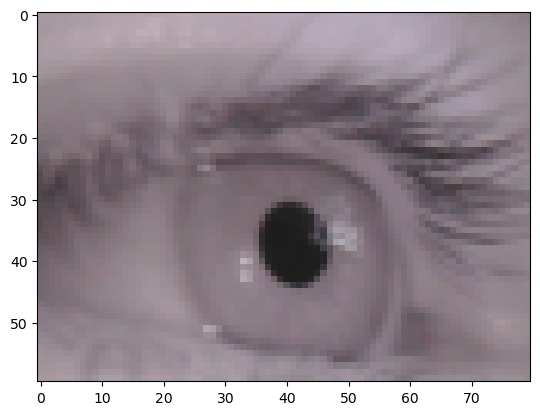

In [23]:
plt.imshow((train_Y[1] /255).permute(1, 2, 0).numpy())

Наконец применим сам алгоритм HOPLS

In [70]:
hopls.fit(train_X, train_Y)

In [25]:
import pickle

In [75]:
with open("hopls.pickle", mode = 'wb') as f:
    pickle.dump(hopls, f)

In [ ]:
with open("hopls.pickle", mode = 'rb') as f:
    hopls = pickle.load(f)

И предскажем один из кадров, чтобы посмотреть насколь хорошо линейное преобразоваание в скрытое пространство восстанавливает изображенеи из фичей

In [71]:
best_Y_pred, best_r, q2s = hopls.predict(train_X[96:97], train_Y[96])

Предыдущий кадр

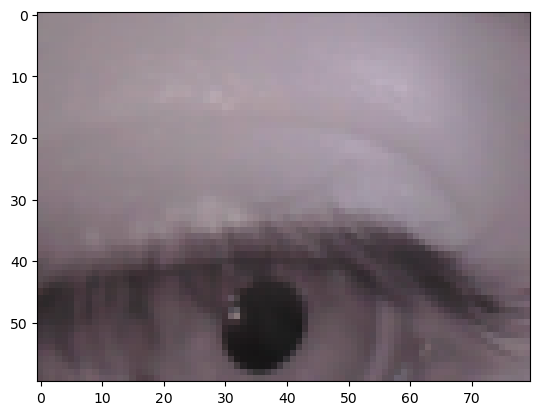

In [72]:
plt.imshow((train_Y[95] /255).permute(1, 2, 0).numpy())

Кадр, который нужно предсказать

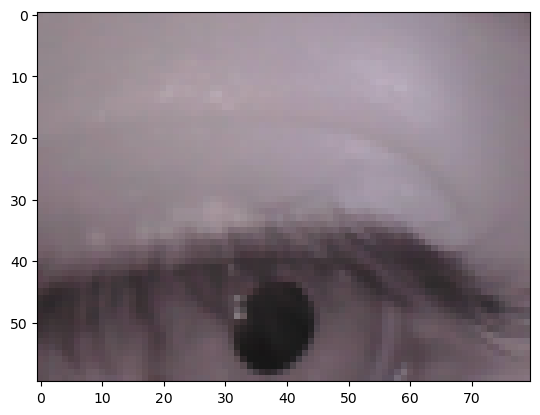

In [73]:
plt.imshow((train_Y[96] /255).permute(1, 2, 0).numpy())

Изображение кадра, предсказанный с помощью HOPLS

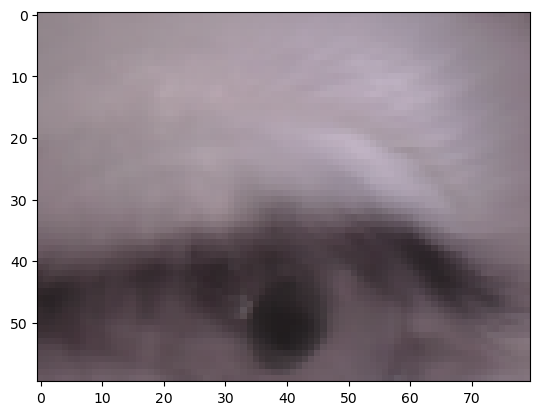

In [74]:
plt.imshow((best_Y_pred /255).permute(1, 2, 0).numpy())


In [17]:
video_features_trasformed

array([[ 5.32139832e+02, -4.98981094e+00, -4.85585403e+00, ...,
         9.80153084e-02,  8.78797174e-02,  3.66032720e-02],
       [ 5.09596466e+02, -9.86233330e+00, -6.08850765e+00, ...,
        -2.11038470e-01, -1.65164471e-02, -1.08539402e-01],
       [ 5.09943848e+02, -7.81235409e+00, -6.26776361e+00, ...,
        -1.93902254e-02,  3.12856734e-02, -1.52598441e-01],
       ...,
       [ 5.68174194e+02,  1.48652372e+01, -5.43119240e+00, ...,
         5.13739586e-02, -2.27188379e-01, -7.90415406e-02],
       [ 5.70418945e+02,  1.48763256e+01, -4.96725178e+00, ...,
        -2.13044882e-01,  2.48802900e-02,  3.55110765e-02],
       [ 5.70943115e+02,  1.55575895e+01, -4.73565531e+00, ...,
        -1.42090082e-01, -1.24946356e-01,  8.33584070e-02]], dtype=float32)

In [18]:
data = pd.read_csv('./LPW/LPW/1/1.txt', sep=" ", header=None)
data.columns = ["X", "Y"]

In [19]:
data.values.shape

(2000, 2)

In [20]:
import HOPLS.hopls
time = 100
hopls2 = HOPLS.hopls.HOPLS(100, [time, 80, 1, 1], [2, 1])

/home/sasha/anaconda3/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [21]:
video_features.shape[0]

2000

In [22]:
train_X_video = []
for i in tqdm(range(video_features.shape[0] - time)):
    begin = i * time
    end = (i +1)* time
    X = video_features_trasformed[i: i +time , :, np.newaxis, np.newaxis]
    train_X_video.append(X)
train_X_video = np.array(train_X_video)

  0%|          | 0/1900 [00:00<?, ?it/s]

In [23]:
import tensorly
train_X_video = tensorly.tensor(torch.tensor(train_X_video, dtype=torch.float64), dtype=torch.float64)
train_Y_movement = tensorly.tensor(torch.tensor(data.values[time:, :, np.newaxis], dtype=torch.float64), dtype=torch.float64)

/home/sasha/anaconda3/lib/python3.11/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


In [24]:
train_X_video.shape

torch.Size([1900, 100, 80, 1, 1])

In [25]:
hopls2.fit(train_X_video[0:1500], train_Y_movement[0:1500])

In [26]:
with open("hopls2.pickle", mode = 'wb') as f:
    pickle.dump(hopls2, f)

In [ ]:
with open("hopls2.pickle", mode = 'rb') as f:
    hopls2 = pickle.loadpickle.dump(f)

In [27]:
best_Y_mov, best_r, q2s  = hopls2.predict(train_X_video, train_Y_movement)

In [28]:
t = np.linspace(0, best_Y_mov.shape[0] - 1, best_Y_mov.shape[0])

In [29]:
best_Y_mov.shape[0]

1900

In [30]:
t

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.897e+03, 1.898e+03,
       1.899e+03])

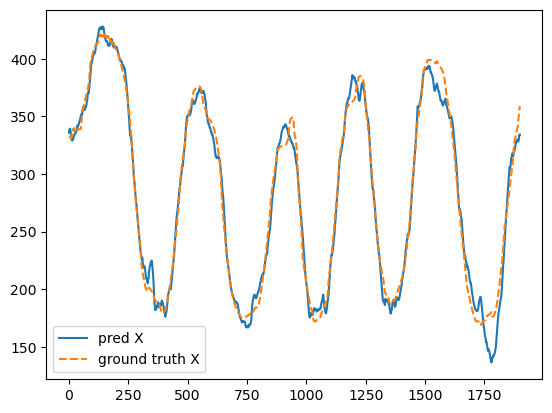

In [31]:

plt.plot(t, best_Y_mov[:, 0], label='pred X')
plt.plot(t, train_Y_movement[:, 0], linestyle='dashed', label='ground truth X')
plt.legend()
plt.show()

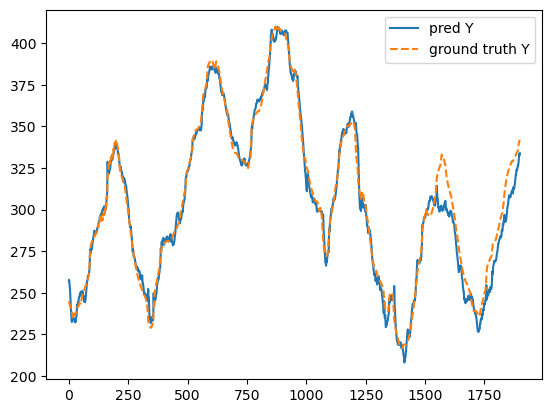

In [32]:
plt.plot(t, best_Y_mov[:, 1], label='pred Y')
plt.plot(t, train_Y_movement[:, 1], linestyle='dashed', label='ground truth Y')
plt.legend()
plt.show()

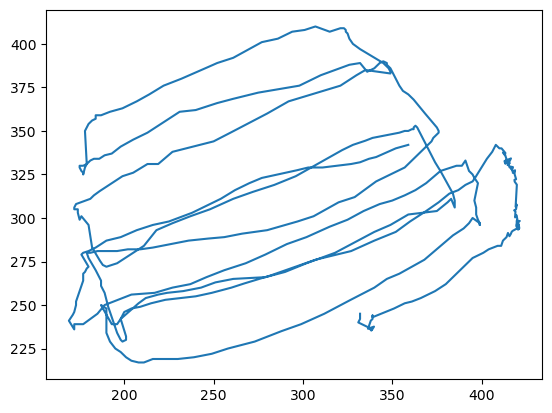

In [33]:
plt.plot(train_Y_movement[:, 0], train_Y_movement[:, 1])
plt.show()

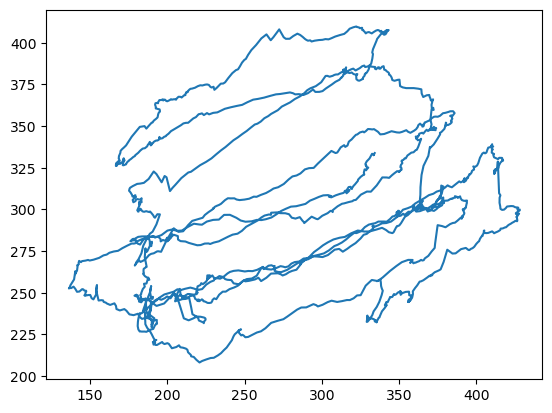

In [38]:
plt.plot(best_Y_mov[: ,0], best_Y_mov[: ,1])
plt.show()

Как видим из-за сжатия размерности кадр немного расплылся. Также есть артефакты связанные с двидением в изображениию Как видим в верхней части кадра оказался лишний ряд ресниц. Но в целом направление движения зрачка оказалось предсказанно верно.

# Вывод
В целом, если пропустить изображение через CNN для получения фичей, по ним можно восстановить следующий кадр с помошью PLS. Для этого даже не требуется использовать скрытое пространство большой размерности. Но в изображении все же получается нечетким и в нем видны следы движения быстрых объектов, но само направление движения угадывается верно.